In [1]:
!pwd

/Users/fanc


In [3]:
import numpy as np
import math
import os
import matplotlib.pyplot as plt

box volume =  85412.72107419185 L =  44.03934515699413 N =  63936 density =  0.7485536018043896
box volume =  72886.3038156358 L =  41.771683204652795 N =  58752 density =  0.8060773687826428
box volume =  86948.99816655756 L =  44.301815844215206 N =  63936 density =  0.7353276213433262


Text(0, 0.5, 'CoM RDF')

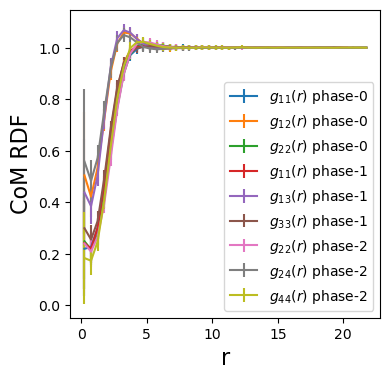

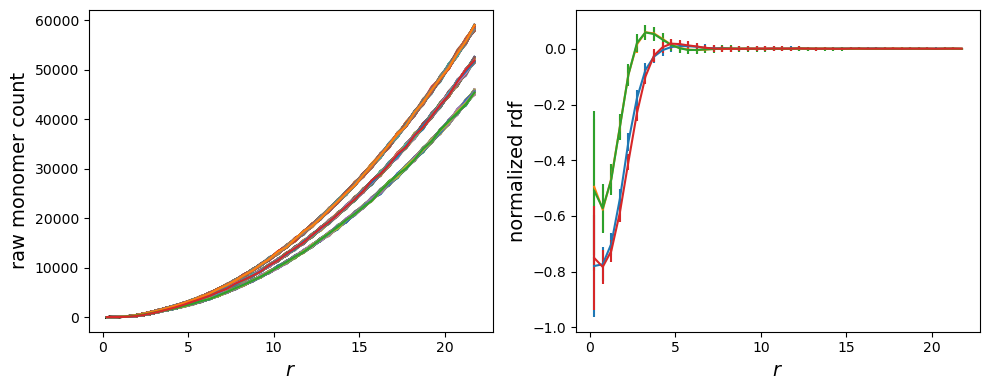

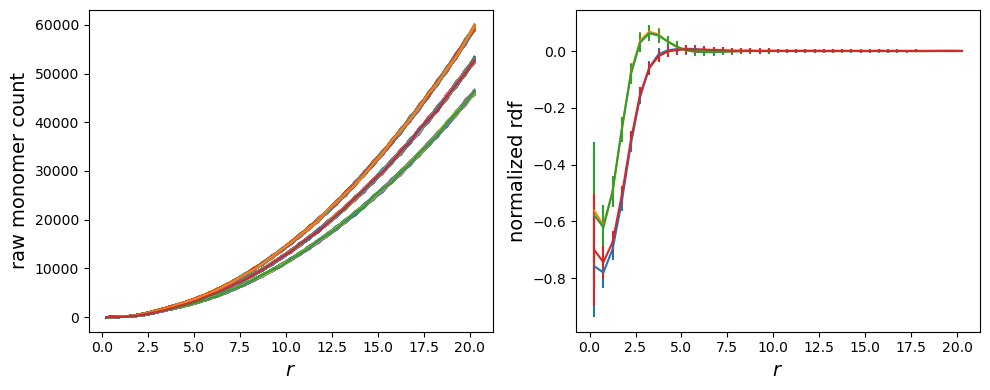

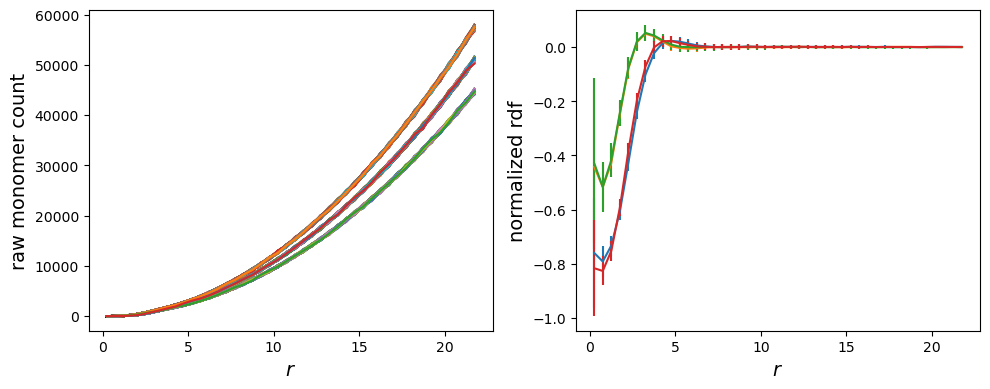

In [5]:
import gzip, pickle
from analysis_atom import read_atom_file, read_traj

# CHANGE the following variables 
Rg_sum = 20.
ddr = 0.5
nchains = 432 * 8 # Total number of chains in the simulation box
scale = '0.375'
testpath = '/Users/fanc/della-home/GS/polymer-test/03_04_pipeline_N3/N4-index4/comparison/mineig0.5/data_no_dilute/diag-100.0-7/NPT-production/rdf-%s/' %scale 



fig0, ax_ = plt.subplots(figsize=(4, 4))
coex_pairs = ['12', '13', '23']
for label in [0, 1, 2][:]:
    collect_data = {}
    input_file = 'rdf-phase-%d.p.gz' %label
    
    # get box volume 
    traj_file = os.path.join(testpath, 'end-phase-%d.atom'%label)
    traj = read_traj(traj_file)
    cnt = 0
    for frame in traj:
        config = frame
        # print(traj_file, config['box'])
        cnt += 1
        if cnt >= 1:
            break
    # config = read_atom_file(os.path.join(testpath, 'end-phase-%d.atom'%label))
    Ls = [side[-1] - side[0] for side in config['box']]
    vol = Ls[0] * Ls[1] * Ls[2]
    N = len(config['atom'])
    print("box volume = ", vol, 'L = ', Ls[0], 'N = ', N, 'density = ', N/vol)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    with gzip.open(os.path.join(testpath, input_file), 'rb') as f:
        while True:
            try:
                data = pickle.load(f)
                for key in data['rdf']:
                    # print(key)
                    if data['n'][key] > 0:
                        if key not in collect_data:
                            collect_data[key] = []
                        dr = data['dr'][:-1]
                        collect_data['dr'] = dr
                        rdf = data['rdf'][key][:-1]/(4 * np.pi * dr**2 * ddr) / data['n'][key] * vol
                        collect_data[key].append(rdf)
                        
                        axs[0].plot(dr, data['rdf'][key][:-1])
            except:
                break

    freq = 10
    com_rdf = {}
    com_pmf = {}
    for key in collect_data:
        if key != 'dr':
            # print(key)
            samples = np.array(collect_data[key])
            com_rdf[key] = np.average(samples, axis=0)
            com_pmf[key] = -np.log(np.average(samples, axis=0))
            axs[1].errorbar(collect_data['dr'], np.average(samples, axis=0)-1, yerr=np.std(samples, axis=0), label=r'$g_{%s%s}(r)$'%(key[0], key[1]))
    
    axs[0].set_xlabel(r'$r$', fontsize=14)
    axs[0].set_ylabel(r'raw monomer count', fontsize=14)
    axs[1].set_xlabel(r'$r$', fontsize=14)
    axs[1].set_ylabel(r'normalized rdf', fontsize=14)

    for key in collect_data:
        if key != 'dr':
            if int(key[0]) <= int(key[1]):
                samples = np.array(collect_data[key])
                # plt.plot(collect_data['dr'], -np.log(np.average(samples, axis=0)), label=key)
                com_rdf[key] = np.average(samples, axis=0)
                com_pmf[key] = -np.log(np.average(samples, axis=0))
                ax_.errorbar(collect_data['dr'], np.average(samples, axis=0), yerr=np.std(samples, axis=0), label=r'$g_{%s%s}(r)$ phase-%d'%(key[0], key[1], label))


    fig.tight_layout()
    # plt.savefig('/Users/fanc/com-rdf-%d-%s.svg' %(1+label, scale))
    
ax_.legend(loc='best')
ax_.set_xlabel('r', fontsize=16)
ax_.set_ylabel('CoM RDF', fontsize=16)
# fig0.savefig('/Users/fanc/rdf.svg')